## Selección del modelo

El objetivo de este notebook es evaluar algunos modelos y seleccionar el mejor para su futuro tuneo.

### Import de los paquetes

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from xepelin.evaluation import save_metrics_to_csv, track_metrics

### Configuraciones

In [2]:
# Variable para setear semilla
SEED = 3

In [3]:
np.random.seed(SEED)

In [4]:
pd.set_option("display.max_columns", None)

### Carga de datos

In [5]:
df = pd.read_csv("../data/processed/dataset_training_v0.csv")
df.shape

(2962, 18)

In [6]:
df.head()

,invoiceId,businessId,payerId,relationDays,relationRecurrence,issuerCancelledInvoices,diasActividadPagador,facturaMorosa,montoFacturaWsz,issuerInvoicesAmountWsz,Clients12MonthsWsz,payerRatioMorosidad,payerAmountFacturas,payerAvgAmountFacturas,payerAvgDiasMora,payerDesvAmount,businessRatioMororsidad,businessAvgDiasMora
0,11654,5,5015,428.0,10.166667,0.021942,2632.0,1,4713103.0,187036960.0,4.0,0.400000,181609529.0,4035767,2.266667,677336.0,0.000000,0.000000
1,13430,5,5015,455.0,9.891304,0.020079,2659.0,0,7879645.0,231623853.0,4.0,0.423077,210861531.0,4055029,2.865385,3824616.0,1.000000,18.000000
2,15957,5,5015,493.0,9.264151,0.016629,2697.0,1,1190417.0,272695026.0,4.0,0.348485,261505599.0,3962206,6.348485,-2771789.0,0.500000,6.000000
3,18135,5,5015,542.0,9.016667,0.014322,2746.0,0,189924.0,321318559.0,3.0,0.375000,278112178.0,3862669,7.041667,-3672745.0,0.666667,4.333333
4,19438,5,5015,562.0,8.920635,0.013314,2766.0,0,3755846.0,346234215.0,3.0,0.376623,297456818.0,3863075,6.181818,-107229.0,0.500000,3.250000


### Split del conjunto de entrenamiento

La estrategia utilizada para evaluar el modelo es separar los datos en train, test y validación:
- El conjunto de **train** será el **80%** de los datos con los que contamos y será utilizado para entrenar el modelo.
- El conjunto de **test**, será utilizado para evaluar la performance del modelo. Representará un **10%** de los datos y será seleccionado aleatoriamente.
- Por último, el conjunto de **validación**, que será utilizado para el tuneo de los hiperparámetros, representará aproximadamente el **10%** de los datos. Dado que este conjunto no tiene que ser visto por el modelo desde ningún lugar, seleccionaremos las últimas facturas emitidas como emulando la utilización del modelo.

In [7]:
# Ordenamos los datos
df = df.sort_values("invoiceId").copy()
df.drop(columns=["invoiceId", "businessId", "payerId"], inplace=True)

# Especificar las características (X) y el objetivo (y)
x = df.drop(columns=["facturaMorosa"], axis=1)
y = df["facturaMorosa"]

# Obtener las últimas 150 filas para validación
x_val = x.iloc[-250:]
y_val = y.iloc[-250:]

# Eliminar las últimas 150 filas de x e y
x = x.iloc[:-250]
y = y.iloc[:-250]

# Dividir el conjunto en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=SEED
)


# Verificamos las formas de los conjuntos resultantes
print("Formas de los conjuntos:")
print("Entrenamiento:", x_train.shape, y_train.shape)
print("Prueba:", x_test.shape, y_test.shape)
print("Validación:", x_val.shape, y_val.shape)


# Mostrar las formas de las particiones
print("Forma de x_train:", x_train.shape)
print("Forma de x_val:", x_val.shape)
print("Forma de x_test:", x_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de y_test:", y_test.shape)

Formas de los conjuntos:
Entrenamiento: (2440, 14) (2440,)
Prueba: (272, 14) (272,)
Validación: (250, 14) (250,)
Forma de x_train: (2440, 14)
Forma de x_val: (250, 14)
Forma de x_test: (272, 14)
Forma de y_train: (2440,)
Forma de y_val: (250,)
Forma de y_test: (272,)


In [8]:
# Creamos un diccionario donde guardamos todo el conjunto de datos
datasets = {
    "train": (x_train, y_train),
    "test": (x_test, y_test),
    "val": (x_val, y_val),
}

### Evaluamos distintos modelos

#### Funciones auxiliares

In [9]:
def run_experiments(
    models: list,
    datasets: dict,
    run_params: dict = None,
    save_csv: bool = False,
    scale_data: bool = False,
):
    """
    Ejecuta experimentos para varios modelos.

    Args:
        models (list): Una lista de tuplas que contienen la clase del modelo y sus parámetros.
        datasets (dict): Un diccionario que contiene los conjuntos de datos de entrenamiento, prueba y validación.
        run_params (dict): Parámetros adicionales para las ejecuciones del experimento (por defecto: None).
        save_csv (bool): Si guardar o no las métricas en archivos CSV (por defecto: False).
        scale_data (bool): Si escalar o no los datos utilizando StandardScaler (por defecto: False).

    Returns:
        None
    """
    x_train, y_train = datasets["train"]
    x_test, y_test = datasets["test"]

    for model_class in models:
        # Inicializar la ejecución
        model_name = model_class.__name__
        print("=" * 130)
        print(f"Métricas para el modelo: {model_name}.")
        print("=" * 130)

        try:
            if scale_data:
                # Construir el pipeline con escalador y modelo
                model = Pipeline(
                    [
                        ("scaler", StandardScaler()),
                        ("model", model_class(random_state=SEED)),
                    ]
                )

                # Entrenar el modelo dentro del pipeline
                model.fit(x_train, y_train)
            else:
                # Construir y entrenar el modelo sin escalador
                model = model_class(random_state=SEED)
                model.fit(x_train, y_train)

            # Tracking de métricas
            metrics_test = track_metrics(
                model,
                x_test,
                y_test,
                threshold=run_params["threshold"],
            )

            if save_csv:
                # Guardar métricas en CSV
                save_metrics_to_csv(metrics_test, run_params, model_name)

        except Exception as e:
            print(e)

        finally:
            print("Experimento completado.")

#### Configuración de los experimentos

In [10]:
# Para remover el sampleo remplazar los string con None
params = {
    "threshold": 0.5,
}

#### Selección de modelos

Dado que la idea es tener un primer acercamiento de la posible performance de cada modelo, se evaluarán los modelos con los parámetros por default. La idea es trabajar con modelos robustos, sobre todo por el inconvenientes que tenemos con algunas variables de outliers. Es por eso que se seleccionan para competir, un arbol de decisión sensillo utilizado como baseline, un random forest y un xgboost.

Dada la complejidad que conlleva seleccionar parámetros, ejecutaremos este paso más adelantes utilizando mecanismos propios para resolver ese tipo de problema.

In [11]:
models = [DecisionTreeClassifier, RandomForestClassifier, XGBClassifier]

**Notas:**

Este tipo de modelos no requiere rescaleo de los datos por lo tanto no lo vamos a realizar.

Métricas para el modelo: DecisionTreeClassifier.
Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.69      0.72      0.70       158
    Positivo       0.58      0.55      0.57       114

    accuracy                           0.65       272
   macro avg       0.64      0.63      0.63       272
weighted avg       0.64      0.65      0.65       272



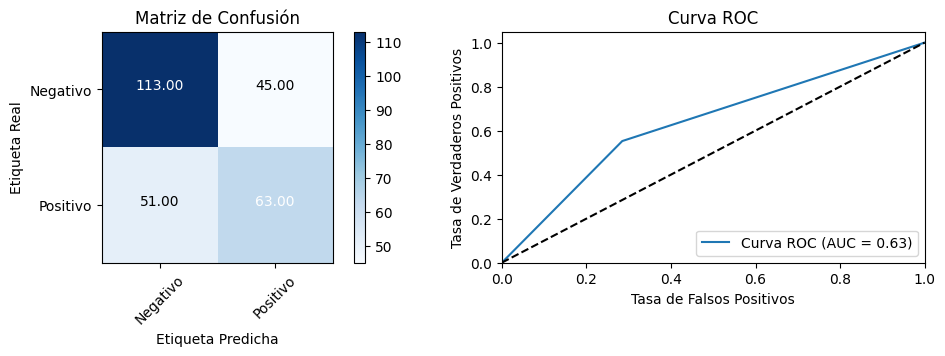

Experimento completado.
Métricas para el modelo: RandomForestClassifier.
Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.72      0.77      0.74       158
    Positivo       0.65      0.60      0.62       114

    accuracy                           0.69       272
   macro avg       0.69      0.68      0.68       272
weighted avg       0.69      0.69      0.69       272



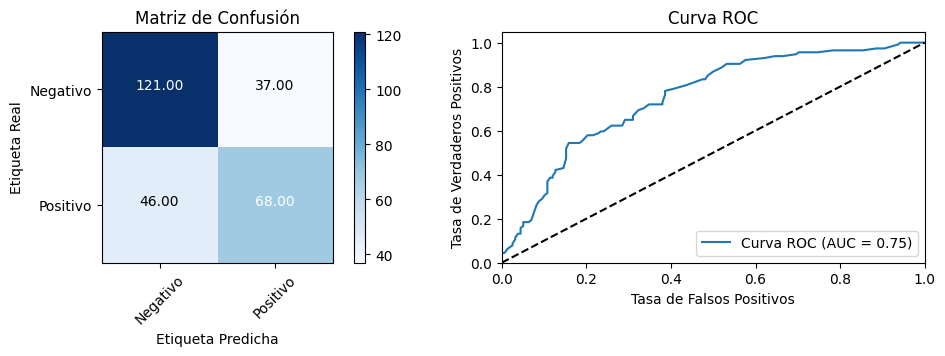

Experimento completado.
Métricas para el modelo: XGBClassifier.
Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.69      0.73      0.71       158
    Positivo       0.60      0.55      0.58       114

    accuracy                           0.66       272
   macro avg       0.65      0.64      0.64       272
weighted avg       0.65      0.66      0.66       272



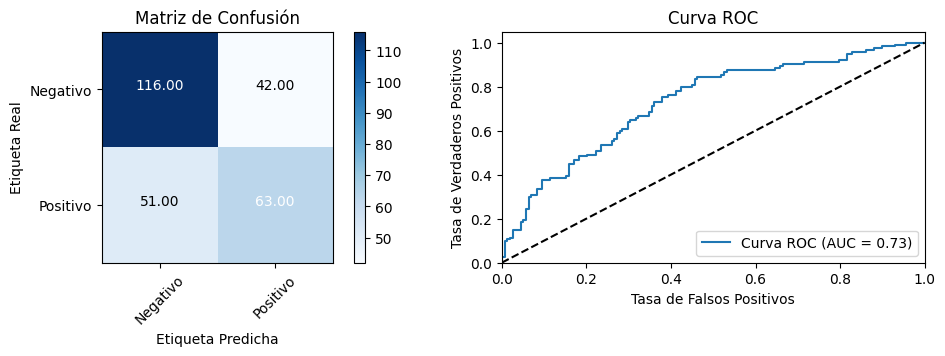

Experimento completado.


In [12]:
run_experiments(models, datasets, params)

**Notas:**

- Existes muchas variables capaz de determinar el desempeño de un modelo de clasifición. La selección de esta métrica depende mucho del tipo de problema que estemos enfrentando (Por ejemplo: problemas balanceados y desbalanceados) y el objetivo que lleve a cabo el negocio.
- Para este último quizas dos métricas fundamentales a observar son el **recall**, **presicion** o el **f1-score**, pero depende mucho del costo económico de la selección de cada uno de estos. Dado que ambos tienen objetivos diferentes.
- Dado que no tenemos esta información o decisión de negocio utilizaremos como métrica de evaluación el **AUC**. Dado que nos encontramos ante un problema balanceado podríamos considerar el acurray tambien. Otra información que utilizaremos para seleccionar el modelo será la complajidad. Modelos simples nos permitirá entrenar más rápido, lo que se traduce en costos.
- Teniendo en cuenta el punto anterior seleccionaremos el **RandomForestClassifier**. El XGBoost suele ser en general de los modelos que mejor se desempeña en problemas tabulares, pero podríamos decir que al instanciarlo con los paramámetros por defecto lo estamos perjudicando dado que no estamos aprovechando su potencial.